In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from metpy.calc import dewpoint_from_specific_humidity, equivalent_potential_temperature, potential_temperature
from metpy.units import units as munits
from tqdm.auto import tqdm
import os
from numba import njit
from pathlib import Path
import re

In [2]:
rhoh2o = 1000 # kg m-3

def get_pr_zonal_metrics(nc_paths):
    result = {}

    for p in tqdm(nc_paths):
        evalname = re.match('.*/(heuer_atm_amip_R2B4_vlvl60.*?)/.*', str(p)).group(1)
        expname = re.match('(heuer_atm_amip_R2B4_vlvl60.*)_\d*_\d*UTC', evalname).group(1)
        result[expname] = {}

        ds = xr.open_dataset(str(p))
        icon_idx = [b'ICON' in v for v in ds.dataset.values].index(True)
        era5_idx = [b'native6' in v for v in ds.dataset.values].index(True)
        obs_idx = [b'OBS' in v for v in ds.dataset.values].index(True)

        pr_icon = ds.pr.sel(dim0=icon_idx)
        pr_era5 = ds.pr.sel(dim0=era5_idx)
        pr_obs = ds.pr.sel(dim0=obs_idx)

        result[expname]['pr_zon_rmse_obs'] = np.sqrt(np.mean((pr_icon - pr_obs).values**2))
        result[expname]['pr_zon_mae_obs'] = np.mean(np.abs(pr_icon - pr_obs).values)
        result[expname]['pr_zon_bias_obs'] = np.mean((pr_icon - pr_obs).values)
        result[expname]['pr_zon_rmse_era5'] = np.sqrt(np.mean((pr_icon - pr_era5).values**2))
        result[expname]['pr_zon_mae_era5'] = np.mean(np.abs(pr_icon - pr_era5).values)
        result[expname]['pr_zon_bias_era5'] = np.mean((pr_icon - pr_era5).values)
        result[expname]['pr_icon'] = pr_icon.values
        result[expname]['pr_obs'] = pr_obs.values

        # add ml weight
        filepath1 = os.path.join('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/', expname, 'extra_2d5_totalmean.nc')
        filepath2 = os.path.join('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments/', expname, 'extra_2d5_totalmean.nc')
        if os.path.exists(filepath1):
            filepath = filepath1
        elif os.path.exists(filepath2):
            filepath = filepath2
        else:
            print('no ml_weight for ', expname)
            continue

        ds = xr.open_dataset(filepath)
        
        result[expname]['ml_weight'] = ds.extra_2d5.values.squeeze()

    return result

In [3]:
pr_nc_paths = [Path(p) for p in sorted(glob('/work/bd1179/b309215/MyIconEval/WorkEvalBackup/**/work/zonal_means_pr/plot/variable_vs_lat_ambiguous_exp_pr_ambiguous_dataset_Amon.nc', recursive=True))]
# pr_nc_paths = [Path(p) for p in sorted(glob('/work/bd1179/b309215/MyIconEval/WorkEvalBackup/*1979*/**/work/zonal_means_pr/plot/variable_vs_lat_ambiguous_exp_pr_ambiguous_dataset_Amon.nc', recursive=True))]
# pr_nc_paths = [Path(p) for p in sorted(glob('/scratch/b/b309215/MyIconEval/WorkEvalBackup/**/work/zonal_means_pr/plot/variable_vs_lat_ambiguous_exp_pr_ambiguous_dataset_Amon.nc', recursive=True))]
# pr_nc_paths = [Path(p) for p in sorted(glob('/scratch/b/b309215/MyIconEval/WorkEvalBackup/*1979*/**/work/zonal_means_pr/plot/variable_vs_lat_ambiguous_exp_pr_ambiguous_dataset_Amon.nc', recursive=True))]
len(pr_nc_paths)

222

In [4]:
pr_nc_paths[:3]

[PosixPath('/work/bd1179/b309215/MyIconEval/WorkEvalBackup/Test/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.01_20250728_212646UTC/recipe_basics_zonal_mean_lines_20250728_213702/work/zonal_means_pr/plot/variable_vs_lat_ambiguous_exp_pr_ambiguous_dataset_Amon.nc'),
 PosixPath('/work/bd1179/b309215/MyIconEval/WorkEvalBackup/Test/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.03_20250728_080501UTC/recipe_basics_zonal_mean_lines_20250728_081904/work/zonal_means_pr/plot/variable_vs_lat_ambiguous_exp_pr_ambiguous_dataset_Amon.nc'),
 PosixPath('/work/bd1179/b309215/MyIconEval/WorkEvalBackup/Test/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.04_20250728_200737UTC/recipe_basics_zonal_mean_lines_20250728_200930/work/zonal_means_pr/plot/variable_vs_lat_ambiguous_exp_pr_ambiguous_dataset_Amon.nc')]

In [5]:
test_ds = xr.open_dataset(pr_nc_paths[0])

In [6]:
pr_metrics = get_pr_zonal_metrics(pr_nc_paths)

  0%|          | 0/222 [00:00<?, ?it/s]

no ml_weight for  heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.01
no ml_weight for  heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.03
no ml_weight for  heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.04
no ml_weight for  heuer_atm_amip_R2B4_vlvl60_baseline_1979
no ml_weight for  heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_60p1_pinnweight0.1_1979_noise0.05
no ml_weight for  heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_60p1_pinnweight0.1_1979_noise0.2
no ml_weight for  heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_60p1_pinnweight0.1_1979_noise0.2
no ml_weight for  heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_60p1_pinnweight0.1_1979_noise0.2_extra2d5fix
no ml_weight for  heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_60p1_pinnweight0.1_1979_noise0.2_extra2d5fix
no ml_weight for  heuer_atm_amip_R2B4_vlvl60

In [7]:
list(pr_metrics.keys())[:5]
[f for f in list(pr_metrics.keys()) if 'fullml' in f]

['heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.01',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.03',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.04',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.05',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.05_2',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.06',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.07',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.08_2',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.12',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.15',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.16',
 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_

## Load ClimSim Precip

In [8]:
# # cs_files = np.array(sorted(glob('/scratch/b/b309215/LEAP/ClimSim_high-res/only_out/**/*.mlo.*.nc', recursive=True)))
# cs_files = np.array(sorted(glob('/scratch/b/b309215/LEAP/ClimSim_low-res/only_out/**/*.mlo.*.nc', recursive=True)))
# print(len(cs_files))

# da_pr_list = []
# da_ps_list = []
# for f in tqdm(cs_files):
#     try:
#         ds = xr.open_dataset(f)
#         da_pr_list.append(ds.cam_out_PRECC)
#         da_ps_list.append(ds.cam_out_PRECSC)
#     except:
#         print(f)
        
# da_pr_cs = xr.concat(da_pr_list, dim='time')*rhoh2o
# da_ps_cs = xr.concat(da_ps_list, dim='time')*rhoh2o

# da_pr_cs_compute = da_pr_cs.compute()
# da_ps_cs_compute = da_ps_cs.compute()

# # da_pr_cs_compute.to_netcdf(f'./precip_cs_da_1stday_allyear_pr.nc')
# # da_ps_cs_compute.to_netcdf(f'./precip_cs_da_1stday_allyear_ps.nc')
# da_pr_cs_compute.to_netcdf(f'./precip_cs_da_1stday_allyear_lowres_pr.nc')
# da_ps_cs_compute.to_netcdf(f'./precip_cs_da_1stday_allyear_lowres_ps.nc')

In [9]:
da_pr_cs_compute = xr.open_dataarray(f'./precip_cs_da_1stday_allyear_pr.nc')
da_ps_cs_compute = xr.open_dataarray(f'./precip_cs_da_1stday_allyear_ps.nc')
# da_pr_cs_compute = xr.open_dataarray(f'./precip_cs_da_1stday_allyear_lowres_pr.nc')
# da_ps_cs_compute = xr.open_dataarray(f'./precip_cs_da_1stday_allyear_lowres_ps.nc')

precip_cs = da_pr_cs_compute + da_ps_cs_compute
precip_cs = precip_cs.mean('time')

cs_grid_path = '/scratch/b/b309215/LEAP/ClimSim_high-res/ClimSim_high-res_grid-info.nc'
# cs_grid_path = '/scratch/b/b309215/LEAP/ClimSim_low-res/ClimSim_low-res_grid-info.nc'
cs_grid = xr.open_dataset(cs_grid_path)

In [10]:
# precip_cs_da = xr.open_dataarray('./precip_cs_da_365cs_days.nc')
# precip_cs_np = precip_cs_da.values
# cs_cells = precip_cs_np.shape[-1]
# cs_days = 365
# precip_cs_np = precip_cs_np.reshape(cs_days, 24, 3, cs_cells)#cs_cells, cs_days, 24, 3)#
# precip_cs = xr.DataArray(precip_cs_np, dims=('day','hour','third','ncol'))
# precip_cs = precip_cs.mean(('third', 'hour', 'day'))

# cs_grid_path = '/scratch/b/b309215/LEAP/ClimSim_high-res/ClimSim_high-res_grid-info.nc'
# cs_grid = xr.open_dataset(cs_grid_path)

In [11]:
def get_zonal_means(precip, lats, nlatbins):
    result = np.empty(nlatbins)
    bin_edges = np.linspace(-90, 90, nlatbins+1)
    # print(bin_edges)
    for i,(l1,l2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        lat_mask = (lats > l1) & (lats < l2)
        # print(lat_mask.sum())
        result[i] = np.mean(precip[lat_mask])
    return result, (bin_edges[1:] + bin_edges[:-1])/2

In [12]:
unit_conv = 1e3*3600*24/rhoh2o # m3 kg-1 * mm m-1 * s d-1
precip_zonal_climsim, lats_climsim = get_zonal_means(precip_cs.values, cs_grid.lat.values, 90)
# precip_zonal_climsim, lats_climsim = get_zonal_means(precip_cs.values, cs_grid.lat.values, 18)#90)
precip_zonal_climsim *= unit_conv

## Plot results

In [13]:
def calc_assymetrie_index(lats, pr):
    lats_interp = np.linspace(lats[0], lats[-1], 180)
    pr_interp = np.interp(lats_interp, lats, pr)
    
    north_mask = (lats_interp > 0) & (lats_interp < 20)
    south_mask = (lats_interp > -20) & (lats_interp < 0)

    # print(north_mask)
    # print(south_mask)
    # print(north_mask | south_mask)
    return (np.mean(pr_interp[north_mask]) - np.mean(pr_interp[south_mask])) / np.mean(pr_interp[north_mask | south_mask])

def calc_eq_precip_index(lats, pr):
    lats_interp = np.linspace(lats[0], lats[-1], 180)
    pr_interp = np.interp(lats_interp, lats, pr)
    
    eq_mask = (lats_interp > -2) & (lats_interp < 2)
    trop_mask = (lats_interp > -20) & (lats_interp < 20)
    # plt.figure()
    # plt.plot(lats_interp, pr_interp)

    # print(np.mean(pr[eq_mask]) , np.mean(pr[trop_mask]))
    return np.mean(pr_interp[eq_mask]) / np.mean(pr_interp[trop_mask])

In [14]:
[m for m in pr_metrics.keys() if 'baseline' in m]

['heuer_atm_amip_R2B4_vlvl60_baseline_1979',
 'heuer_atm_amip_R2B4_vlvl60_baseline']

A_P index obs:  0.4544982813261035
E_P index obs:  0.9200140560499772
A_P index cs:  0.2678659869213042
E_P index cs:  0.9727916251940321
TPAI-bias cs:  -0.18663229440479928
EPI-bias cs :  0.05277756914405485
pr_zon_rmse cs :  0.884470750313558
pr_zon_mae cs :  0.7051713010413362
---
heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml
pr_zon_rmse_obs:  0.6000186551518518
pr_zon_mae_obs:  0.44653258836931653
TPAI:  0.2534240492861504
TPAI-bias:  -0.20107423203995306
EPI:  0.7160720465440195
EPI-bias:  -0.20394200950595776
---
heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_60p1_pinn385weight0.1
pr_zon_rmse_obs:  0.38733544441363965
pr_zon_mae_obs:  0.29952952133284677
TPAI:  0.45107493741013444
TPAI-bias:  -0.003423343915969046
EPI:  0.9113629460049372
EPI-bias:  -0.008651110045040045
---
heuer_atm_amip_R2B4_vlvl60_baseline
pr_zon_rmse_obs:  0.49108442873456915
pr_zon_mae_obs:  0.3905255557762252
TPAI:  0.4165794965077136
TPAI-bias:  -0.0379187848

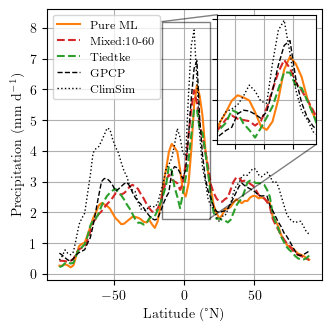

In [19]:
from setup_mpl_tex import setup_mpl_tex

setup_mpl_tex()

# todo: change for 2nd plot
expnames = ['heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml',
            # 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml_pinn385weight0.01',
            'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_60p1_pinn385weight0.1',
            'heuer_atm_amip_R2B4_vlvl60_baseline'
            # 'heuer_atm_amip_R2B4_vlvl60_baseline_1979'
]
#---
# expnames = [
#     # 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.03',
#     # 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_60p1_pinnweight0.1_1979_noise0.05',
#     # 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_80p1_pinnweight0.1_1979_noise0.1',
#     'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.2',
#     'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_60p1_pinnweight0.1_1979_noise0.2_extra2d5fix',
#     # 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_60p1_pinnweight0.1_1979_noise0.05',
#     # 'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_70p1_pinnweight0.1_1979_noise0.05',
#     'heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_80p1_pinnweight0.1_1979_noise0.2_extra2d5fix',
#     'heuer_atm_amip_R2B4_vlvl60_baseline_1979'
# ]

# linestyles = ['-' for _ in range(len(expnames))]
linestyles = ['-', '--', '--', '-']

cmap = plt.get_cmap('tab10')
# colors = [cmap(0.1), cmap(0.3), cmap(0.2)]
colors = [cmap(0.1), cmap(0.3), cmap(0.2), cmap(0.4), cmap(0.5), cmap(0.6)]

# todo: change for 2nd plot
labels = [
          'Pure ML',
          'Mixed:10-60',
          'Tiedtke']
#---
# labels = [# '$10p_0\_60p_1\_0.1\\alpha$',
#           'Pure ML',
#           # 'Pure ML2',
#           'Mixed:10-60',
#           # 'Mixed:10-70',
#           'Mixed:10-80',
#           'Tiedtke']

xs = test_ds.lat.values

# todo: change for 2nd plot
fig, ax = plt.subplots(constrained_layout=True, figsize=(6.4/2, 4.8*2/3))
#---
# fig, ax = plt.subplots(constrained_layout=True)
pr_obs = pr_metrics[expnames[-1]]['pr_obs']
# pr_obs = pr_metrics['heuer_atm_amip_R2B4_vlvl60_baseline_1979']['pr_obs']

obs_tpai = calc_assymetrie_index(xs, pr_obs)
obs_epi = calc_eq_precip_index(xs, pr_obs)
print('A_P index obs: ', obs_tpai)
print('E_P index obs: ', obs_epi)
cs_tpai = calc_assymetrie_index(lats_climsim, precip_zonal_climsim)
cs_epi = calc_eq_precip_index(lats_climsim, precip_zonal_climsim)
print('A_P index cs: ', cs_tpai)
print('E_P index cs: ', cs_epi)
print('TPAI-bias cs: ', cs_tpai - obs_tpai)
print('EPI-bias cs : ', cs_epi - obs_epi)
print('pr_zon_rmse cs : ', np.sqrt(np.mean((precip_zonal_climsim - pr_obs)**2)))
print('pr_zon_mae cs : ', np.mean(np.abs(precip_zonal_climsim - pr_obs)))

for i,(expname,plot_label) in enumerate(zip(expnames,labels)):
    ax.plot(xs, pr_metrics[expname]['pr_icon'], label=plot_label, color=colors[i], ls=linestyles[i])
    print('---')
    print(expname)
    print('pr_zon_rmse_obs: ', pr_metrics[expname]['pr_zon_rmse_obs'])
    print('pr_zon_mae_obs: ', pr_metrics[expname]['pr_zon_mae_obs'])
    print('TPAI: ', calc_assymetrie_index(xs, pr_metrics[expname]['pr_icon']))
    print('TPAI-bias: ', calc_assymetrie_index(xs, pr_metrics[expname]['pr_icon']) - obs_tpai)
    print('EPI: ', calc_eq_precip_index(xs, pr_metrics[expname]['pr_icon']))
    print('EPI-bias: ', calc_eq_precip_index(xs, pr_metrics[expname]['pr_icon']) - obs_epi)

# ax.plot(xs, pr_metrics[expnames[-1]]['pr_obs'], label='GPCP', color='black', lw=1, ls='--')
ax.plot(xs, pr_obs, label='GPCP', color='black', lw=1, ls='--')

ax.plot(lats_climsim, precip_zonal_climsim, label='ClimSim', color='black', lw=1, ls=':')

ax.set_ylabel('Precipitation (mm d$^{-1}$)')
ax.set_xlabel('Latitude (°N)')
ax.legend(ncol=1, fontsize='small', loc='upper left')
ax.grid()

# inset Axes....
# x1, x2, y1, y2 = -1, 17, 4.5, 7  # subregion of the original image
x1, x2, y1, y2 = -16, 18, 1.8, 8.2  # subregion of the original image
axins = ax.inset_axes(
    [0.62, 0.5, 0.36, 0.48],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# axins.imshow(Z2, extent=extent, origin="lower")
for i,(expname,plot_label) in enumerate(zip(expnames,labels)):
    axins.plot(xs, pr_metrics[expname]['pr_icon'], color=colors[i], ls=linestyles[i])
axins.plot(xs, pr_obs, label='GPCP', color='black', lw=1, ls='--')
axins.plot(lats_climsim, precip_zonal_climsim, label='ClimSim', color='black', lw=1, ls=':')
axins.grid()
ax.indicate_inset_zoom(axins, edgecolor="black")

# todo: change for 2nd plot
# fig.savefig('Figures/Zonal_Mean_Precip_vs_GPCP_inset.pdf')#_half-page.pdf')
#---
# fig.savefig('Figures/20y_Zonal_Mean_Precip_vs_GPCP_climsimlowres.pdf')#_half-page.pdf')
# fig.savefig('Figures/20y_Zonal_Mean_Precip_vs_GPCP_climsimold.pdf')#_half-page.pdf')
# fig.savefig('Figures/20y_Zonal_Mean_Precip_vs_GPCP.pdf')#_half-page.pdf')

plt.show()

In [ ]:
# one year
A_P index obs:  0.4544982813261035
E_P index obs:  0.9200140560499772
A_P index cs:  0.20189623775175738
E_P index cs:  1.2833513475828242
TPAI-bias cs:  -0.2526020435743461
EPI-bias cs :  0.363337291532847
---
heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml
pr_zon_rmse_obs:  0.6000186551518518
pr_zon_mae_obs:  0.44653258836931653
TPAI:  0.2534240492861504
TPAI-bias:  -0.20107423203995306
EPI:  0.7160720465440195
EPI-bias:  -0.20394200950595776
---
heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_60p1_pinn385weight0.1
pr_zon_rmse_obs:  0.38733544441363965
pr_zon_mae_obs:  0.29952952133284677
TPAI:  0.45107493741013444
TPAI-bias:  -0.003423343915969046
EPI:  0.9113629460049372
EPI-bias:  -0.008651110045040045
---
heuer_atm_amip_R2B4_vlvl60_baseline
pr_zon_rmse_obs:  0.49108442873456915
pr_zon_mae_obs:  0.3905255557762252
TPAI:  0.4165794965077136
TPAI-bias:  -0.037918784818389895
EPI:  0.8482026342654599
EPI-bias:  -0.07181142178451727

# 20 years
A_P index obs:  0.1882225955988089
E_P index obs:  1.1626439758129867
A_P index cs:  0.20189623775175738
E_P index cs:  1.2833513475828242
TPAI-bias cs:  0.013673642152948473
EPI-bias cs :  0.12070737176983748
pr_zon_rmse cs :  0.9044686030538048
pr_zon_mae cs :  0.7139715500697292
---
heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_fullml_1979_noise0.2
pr_zon_rmse_obs:  0.45861030199983965
pr_zon_mae_obs:  0.3472183167934418
TPAI:  0.25731248871671286
TPAI-bias:  0.06908989311790395
EPI:  0.9236477214008314
EPI-bias:  -0.23899625441215533
---
heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_60p1_pinnweight0.1_1979_noise0.2_extra2d5fix
pr_zon_rmse_obs:  0.3804335967906432
pr_zon_mae_obs:  0.29492453965875837
TPAI:  0.2747332333693326
TPAI-bias:  0.08651063777052367
EPI:  0.9008694334980191
EPI-bias:  -0.26177454231496766
---
heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_10p0_80p1_pinnweight0.1_1979_noise0.2_extra2d5fix
pr_zon_rmse_obs:  0.3753166583733337
pr_zon_mae_obs:  0.28894645108116995
TPAI:  0.27917557427106615
TPAI-bias:  0.09095297867225724
EPI:  0.9018758123306138
EPI-bias:  -0.26076816348237297
---
heuer_atm_amip_R2B4_vlvl60_baseline_1979
pr_zon_rmse_obs:  0.38210189122978394
pr_zon_mae_obs:  0.2683737999863095
TPAI:  0.24734782682224973
TPAI-bias:  0.05912523122344082
EPI:  0.9090081988122088
EPI-bias:  -0.2536357770007779